In [71]:
import numpy as np
from scipy.stats import chi2

import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression as lgreg
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def ll_ratio_test(ll_constrained, ll_unconstrained):
    """
    Compute the ll_ratio test 
    against the null
    """
    ratio = 2*(ll_unconstrained - ll_constrained)
    p = chi2.sf(ratio, df=1)
    return p

In the dataset, a large sample of adult participants from the general community completed a five factor model personality questionnaire, and three self-report measures related to mood disorders: The Mood Disorder Questionnaire (MDQ), the Hypomania Checklist (HCL), and the Quick Inventory of Depressive Symptomatology (QIDS). The latter three measures were scored such that individuals ended up with a positive screen (scored 1), or a negative screen (scored 0) for being considered 'at-risk' for developing a mood disorder. The researchers were interested in the extent to which the personality variables could predict risk for mood disorders in this dataset. 

In [4]:
df = pd.read_csv('data_lab.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4464 non-null   int64  
 1   Gender                  4464 non-null   int64  
 2   OpenessTotal            4464 non-null   float64
 3   ConscientiousnessTotal  4464 non-null   float64
 4   ExtraversionTotal       4464 non-null   float64
 5   AgreeablenessTotal      4464 non-null   float64
 6   NeuroticismTotal        4464 non-null   float64
 7   MDQ_screen              4464 non-null   int64  
 8   QIDS_screen             4464 non-null   int64  
 9   HCL_screen              4464 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 348.9 KB


In [5]:
questionnaires = [
    'OpenessTotal', 
    'ConscientiousnessTotal', 
    'ExtraversionTotal', 
    'AgreeablenessTotal', 
    'NeuroticismTotal'
]
screening_variables = ['MDQ_screen', 'QIDS_screen', 'HCL_screen']

Q1. Check that the three outcome variables have been labeled correctly 1 = positive screen, 0 = negative screen. In this research scenario, which category should we consider the target group and which should we consider the reference group?

In [6]:
df[screening_variables].describe()

,MDQ_screen,QIDS_screen,HCL_screen
count,4464.000000,4464.000000,4464.000000
mean,0.163978,0.173611,0.152554
std,0.370298,0.378817,0.359597
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


Q2. What proportion of the sample have a positive screen for each of the three outcome variables?

In [7]:
df[screening_variables].sum() / len(df)

MDQ_screen     0.163978
QIDS_screen    0.173611
HCL_screen     0.152554
dtype: float64

Q3. Is receiving a positive or negative screen on the QIDS associated with gender? What proportion of men and women have a received a positive screen in relation to the total number of males and females, respectively?

In [8]:
df.groupby(['Gender', 'QIDS_screen']).size()

Gender  QIDS_screen
0       0              1963
        1               295
1       0              1726
        1               480
dtype: int64

In [9]:
df.groupby('Gender')['QIDS_screen'].sum() / df.groupby('Gender')['QIDS_screen'].count()

Gender
0    0.130647
1    0.217588
Name: QIDS_screen, dtype: float64

Q4. What is the odds ratio for being a positive screen for females compared to males? 

In [10]:
(480 * 1963) / (295 * 1762)

1.8127320648723524

Q5. The research team initially wanted to examine which of the five personality traits significantly relate to the screening outcome on the QIDS. Run a binomial logistic model. First, check that the reference level is set correctly for the outcome variable in the menu (it should say 'negative'). Why does the overall model test have 5df? Does the model fit information in the output suggest this set of predictors provide a reasonable fit to the outcome variable? Provide the key parts of the output below. What is the deviance value for the null model?

In [96]:
endog = df['QIDS_screen'].values

exog = df[questionnaires].values
exog = (exog - exog.mean()) / exog.std()
exog = sm.add_constant(exog)

logit_mod = sm.Logit(endog, exog)
residuals = logit_mod.fit()

residuals.summary()

Optimization terminated successfully.
         Current function value: 0.369630
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4464
Model:                          Logit   Df Residuals:                     4458
Method:                           MLE   Df Model:                            5
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                  0.1992
Time:                        20:42:54   Log-Likelihood:                -1650.0
converged:                       True   LL-Null:                       -2060.4
Covariance Type:            nonrobust   LLR p-value:                3.649e-175
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3994      0.177    -19.227      0.000      -3.746      -3.053
x1             0.3833      0.106      3.605      0.000       0.175       0.592
x2            -0.6065      0.108     -5.633      0.000      -0.818      -0.395
x3            -0.1713      0.080     -2.139      0.032      -0.328      -0.014
x4            -0.1878      0.106     -1.771      0.077      -0.396       0.020
x5             2.1156      0.097     21.907      0.000       1.926       2.305
==============================================================================
"""

Q6. What does the omnibus likelihood ratio tests table tell us? Why do the statistics have 1 df?

In [104]:
full_model = sm.Logit(endog, exog)
full_residuals = full_model.fit()

for coef in range(1, 6):
    
    constrained_mod = sm.Logit(endog, np.delete(exog, coef, 1))
    constrained_residuals = constrained_mod.fit()
    
    p = ll_ratio_test(
        constrained_residuals.llf,
        full_residuals.llf,
    )
    print('')
    print(f'Coeff {coef}: {round(p, 3)}')
    print('')

Optimization terminated successfully.
         Current function value: 0.369630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371107
         Iterations 7

Coeff 1: 0.0

Optimization terminated successfully.
         Current function value: 0.373250
         Iterations 7

Coeff 2: 0.0

Optimization terminated successfully.
         Current function value: 0.370145
         Iterations 7

Coeff 3: 0.032

Optimization terminated successfully.
         Current function value: 0.369979
         Iterations 7

Coeff 4: 0.078

Optimization terminated successfully.
         Current function value: 0.442572
         Iterations 6

Coeff 5: 0.0



Q7: Examine the omnibus likelihood ratio tests for each predictor, and the information in the model coefficients table. What do they suggest in terms of which of the personality variables are best predictor/s of the screening outcome for the QIDS? What should we bear in mind when interpreting these coefficients in this specific dataset?

Q8. On the basis of the above results, the researchers decided to run another model where they examined the effect of neuroticism on the outcome, but this time including age and gender as control variables (given the association gender has with the outcome, as shown earlier). Re-run the binomial LR model, with age, gender and neuroticism as predictors. Summarise the key results below. What conclusions would we reach?

In [106]:
endog = df['QIDS_screen'].values

exog = df[questionnaires + ['Age']].values
exog = (exog - exog.mean()) / exog.std()
exog = np.append(exog, df['Gender'].values.reshape(-1, 1), axis=1)
exog = sm.add_constant(exog)

logit_mod = sm.Logit(endog, exog)
residuals = logit_mod.fit()

residuals.summary()

Optimization terminated successfully.
         Current function value: 0.369115
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4464
Model:                          Logit   Df Residuals:                     4456
Method:                           MLE   Df Model:                            7
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                  0.2003
Time:                        20:52:28   Log-Likelihood:                -1647.7
converged:                       True   LL-Null:                       -2060.4
Covariance Type:            nonrobust   LLR p-value:                6.108e-174
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6260      0.197    -18.401      0.000      -4.012      -3.240
x1             0.3937      0.101      3.915      0.000       0.197       0.591
x2            -0.5783      0.100     -5.756      0.000      -0.775      -0.381
x3            -0.1864      0.076     -2.463      0.014      -0.335      -0.038
x4            -0.2043      0.100     -2.052      0.040      -0.399      -0.009
x5             1.9131      0.093     20.663      0.000       1.732       2.095
x6            -0.0492      0.175     -0.281      0.779      -0.393       0.294
x7             0.2050      0.096      2.132      0.033       0.017       0.393
==============================================================================
"""

Q8. Does neuroticism significantly enhance the model fit when it enters the LR model? To check this, you will need to use the model builder menu to add another block to the model, and re-organise the predictors to address this question. 

In [107]:
endog = df['QIDS_screen'].values

exog = df[questionnaires + ['Age']].values
exog = (exog - exog.mean()) / exog.std()
exog = np.append(exog, df['Gender'].values.reshape(-1, 1), axis=1)
exog = sm.add_constant(exog)

full_model = sm.Logit(endog, exog)
full_residuals = full_model.fit()

constrained_model = sm.Logit(endog, np.delete(exog, 5, 1))
constrained_residuals = constrained_model.fit()

Optimization terminated successfully.
         Current function value: 0.369115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431744
         Iterations 6


In [108]:
p = ll_ratio_test(
    constrained_residuals.llf,
    full_residuals.llf
)
print(f'Neuroticism: {p}')

Neuroticism: 1.2828962163015345e-123


Q9. Use the options in the prediction menu to examine how well this set of predictors classifies cases, relative to the observed data. 

In [109]:
predictions = lgreg().fit(exog, endog).predict_proba(exog)
print(f'f1 score: {f1_score(predictions.argmax(1).reshape(-1, 1), endog)}')

f1 score: 0.30725190839694655


Q10: What happens when you change the cutoff value for the classifications to 0.2?

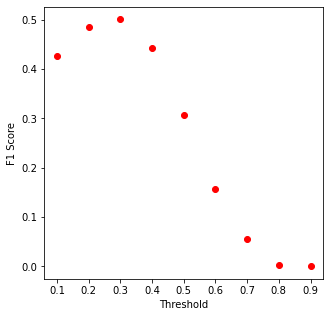

In [110]:
plt.figure(figsize=(5, 5))
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    
    predictions_new = [1 if i[1] >= threshold else 0 for i in predictions]
    score = f1_score(predictions_new, endog)
    
    plt.scatter(threshold, score, c='r')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

Q11: As a final analysis, the team wanted to see if gender moderated the effect of neuroticism on the QIDS screening outcome. Use the model builder to run this analysis in Jamovi. What would you conclude?

In [118]:
full_model = sm.Logit(endog, exog[:, [0, 5, 7]])
full_residuals = full_model.fit()
    
constrained_mod = sm.Logit(endog, exog[:, [0, 5]])
constrained_residuals = constrained_mod.fit()

Optimization terminated successfully.
         Current function value: 0.375731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375742
         Iterations 7

p: 0.761



In [121]:
constrained_residuals.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4464
Model:                          Logit   Df Residuals:                     4462
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                  0.1859
Time:                        20:57:57   Log-Likelihood:                -1677.3
converged:                       True   LL-Null:                       -2060.4
Covariance Type:            nonrobust   LLR p-value:                1.181e-168
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3867      0.105    -32.388      0.000      -3.592      -3.182
x1             2.0131      0.087     23.240      0.000       1.843       2.183
==============================================================================
"""

In [122]:
full_residuals.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4464
Model:                          Logit   Df Residuals:                     4461
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                  0.1860
Time:                        20:57:57   Log-Likelihood:                -1677.3
converged:                       True   LL-Null:                       -2060.4
Covariance Type:            nonrobust   LLR p-value:                3.916e-167
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3962      0.109    -31.119      0.000      -3.610      -3.182
x1             2.0069      0.089     22.565      0.000       1.833       2.181
x2             0.0277      0.091      0.305      0.761      -0.150       0.206
==============================================================================
"""

In [123]:
p = ll_ratio_test(
    constrained_residuals.llf,
    full_residuals.llf,
    
)
print('')
print(f'Mediation Neuroticism: {round(p, 3)}')
print('')


Mediation Neuroticism: 0.761

